In [148]:
# ! pipenv install scikit-learn
# ! pipenv install imbalanced-learn
# ! pipenv install xgboost
# ! pipenv install pandas
# ! pipenv install numpy
# ! pipenv install matplotlib
# ! pipenv install seaborn
# ! pipenv install statsmodels
# ! brew install libomp

In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [150]:
df = pd.read_csv('Bank Customer Churn Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [152]:
df.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

In [153]:
df.drop('customer_id', axis=1, inplace=True)

In [154]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
object_columns = df.select_dtypes(include=['object']).columns
for col in object_columns:
    df[col] = le.fit_transform(df[col])
df

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,1,39,5,0.00,2,1,0,96270.64,0
9996,516,0,1,35,10,57369.61,1,1,1,101699.77,0
9997,709,0,0,36,7,0.00,1,0,1,42085.58,1
9998,772,1,1,42,3,75075.31,2,1,0,92888.52,1


In [155]:
cols = ['credit_score', 'age'] # one or more

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

<Axes: xlabel='churn', ylabel='count'>

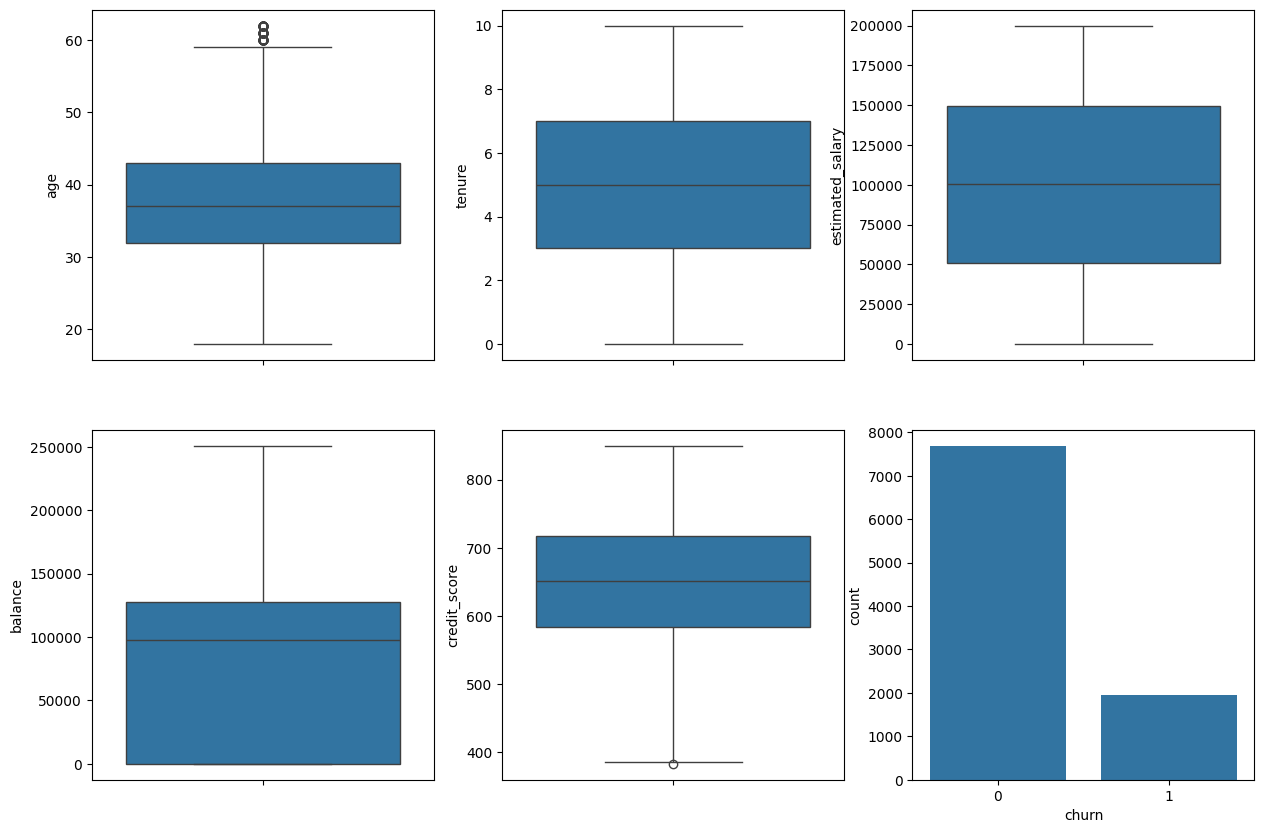

In [156]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
sns.boxplot(data=df['age'], ax=ax[0][0])
sns.boxplot(data=df['tenure'], ax=ax[0][1])
sns.boxplot(data=df['estimated_salary'], ax=ax[0][2])
sns.boxplot(data=df['balance'], ax=ax[1][0])
sns.boxplot(data=df['credit_score'], ax=ax[1][1])
sns.barplot(data=df['churn'].value_counts(), ax=ax[1][2])

In [157]:
from sklearn.feature_selection import chi2

X = df.drop('churn', axis=1)
y = df['churn']

chi2_stats, p_values = chi2(X, y)
stat = pd.DataFrame({
    'feature': X.columns,
    'chi2': chi2_stats.round(3),
    'p-value': p_values.round(3)
})
stat.sort_values(by='chi2', ascending=False).reset_index(drop=True)

,feature,chi2,p-value
0,balance,6692084.309,0.000
1,estimated_salary,26475.323,0.000
2,age,2534.656,0.000
3,active_member,98.306,0.000
4,gender,49.787,0.000
5,credit_score,36.789,0.000
6,country,10.334,0.001
7,products_number,5.446,0.020
8,tenure,2.652,0.103
9,credit_card,0.205,0.651


In [158]:
df.drop(['tenure', 'credit_card'], axis=1, inplace=True)

/var/folders/yl/cjbc6vzx6w50_0rc75y44q280000gn/T/ipykernel_31067/2583300578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['tenure', 'credit_card'], axis=1, inplace=True)


In [159]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_with_const = sm.add_constant(df)

vif_data = pd.DataFrame({
    'feature': df_with_const.columns,
    'vif': [variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])]
})
vif_data.sort_values(by='vif', ascending=False).reset_index(drop=True)

,feature,vif
0,const,83.273528
1,churn,1.205623
2,age,1.154860
3,balance,1.120954
4,products_number,1.104610
5,active_member,1.027550
6,gender,1.012713
7,country,1.006621
8,credit_score,1.001097
9,estimated_salary,1.000716


In [160]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import NearMiss

smote = NearMiss()
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=11)

<Axes: xlabel='churn', ylabel='count'>

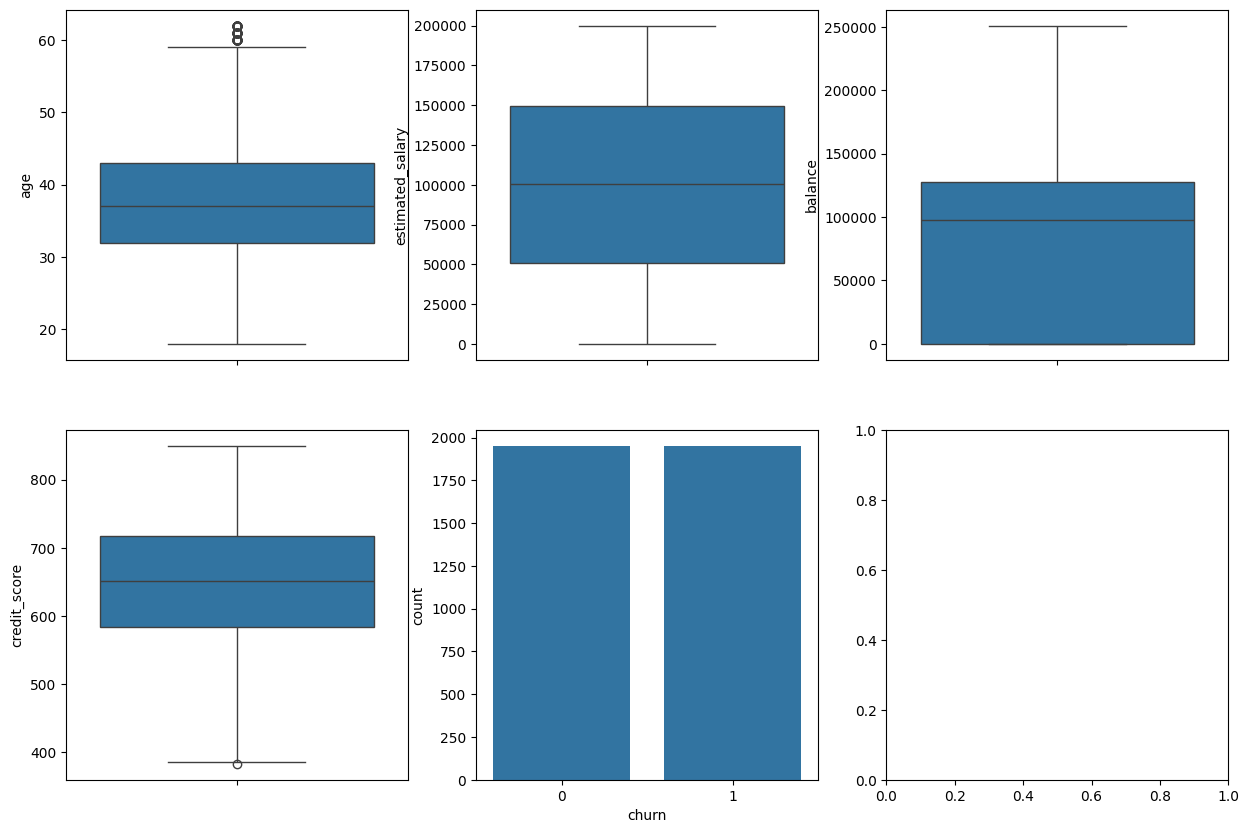

In [161]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
sns.boxplot(data=df['age'], ax=ax[0][0])
sns.boxplot(data=df['estimated_salary'], ax=ax[0][1])
sns.boxplot(data=df['balance'], ax=ax[0][2])
sns.boxplot(data=df['credit_score'], ax=ax[1][0])
sns.barplot(data=y_resampled.value_counts(), ax=ax[1][1])

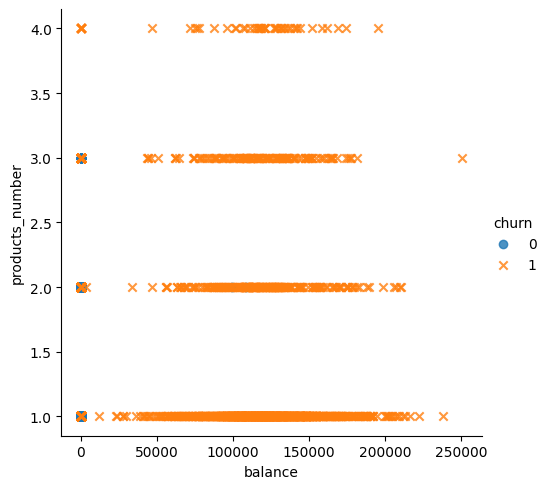

In [162]:
sns.lmplot(x='balance', y='products_number', hue='churn', height=5, markers=['o', 'x'], fit_reg=False, data=X_resampled.join(y_resampled))
plt.savefig('product-cross-balance.png')

In [163]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

model = RandomForestClassifier().fit(X_train, y_train)
cv_results = cross_validate(model, X_test, y_test, cv=3, scoring=["accuracy", "f1", "roc_auc"])
f1 = cv_results['test_f1'].mean()
auc = cv_results['test_roc_auc'].mean()
accuracy = cv_results['test_accuracy'].mean()

print(f'accuracy: {accuracy:.2f}')
print(f'f1: {f1:.2f}')
print(f'auc: {auc:.2f}')

accuracy: 0.92
f1: 0.92
auc: 0.97


In [164]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

rfc_params = {'n_estimators': [10, 50, 100, 200],
        'max_depth': [5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]}

cv = StratifiedKFold(n_splits=5)
gs_best = GridSearchCV(model, rfc_params, cv=cv, n_jobs=-1, verbose=3).fit(X_train, y_train)
final_model = model.set_params(**gs_best.best_params_)

cv_results = cross_validate(final_model, X_test, y_test, cv=cv, scoring=['accuracy', 'f1', 'roc_auc'])
f1 = cv_results['test_f1'].mean()
auc = cv_results['test_roc_auc'].mean()
accuracy = cv_results['test_accuracy'].mean()

print(f'accuracy: {accuracy:.2f}')
print(f'f1: {f1:.2f}')
print(f'auc: {auc:.2f}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.923 total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.913 total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.915 total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.920 total time=   0.1s
[CV 4/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.925 total time=   0.1s
[CV 4/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.934 total time=   0.2s
[CV 2/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.915 total time=   0.2s
[CV 1/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.920 total time=   0.2s
[CV 5/5] 

/Users/pariya47/.local/share/virtualenvs/churn-mai-14eqZlk5/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


accuracy: 0.93
f1: 0.93
auc: 0.98


Text(0.5, 63.222222222222186, 'Predicted label')

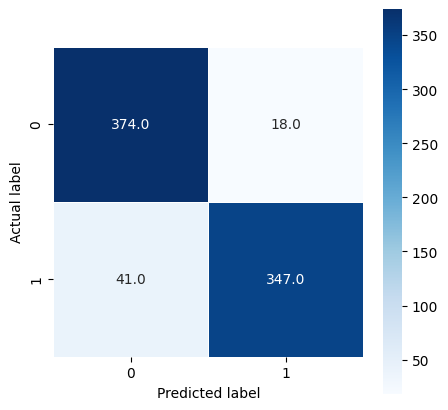

In [166]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(model, X_test, y_test, cv=cv)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square=True, cmap='Blues', fmt=".1f")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')